# Recommender Systems: Validation
---


The goal of this document is to provide a solid basis for validating recommender systems. Along the way we aim to highlight pitfalls and best practices, as well as trade-offs between different approaches.

### Outline
---

1. [**Introduction**](#intro)
2. [**Testing your recsys: holding out data**](#splitting)

    - [Leave-k-out](#leave-k-out)
    - [Leave-one-out](#leave-one-out)
    - [M-fold](#m-fold)    
    - [Validation Sets](#validation)    
    - [Summary: Holdout recommendations and best practices](#holdout summary)    
<br>
3. [**Evaluation Metrics**](#metrics)

    - [Error Metrics](#error)
    - [Classification Metrics](#class)


### Dependencies
---

This notebook should ship with 'validation_figs.py', 'algorithms.py' and 'utils.py', which will provide some basic algorithms and functions used in this demo.  In addition this notebook requires the following libraries:
- numpy
- matplotlib
- seaborn
- scikit-learn

### Implementation Details
---
The code shown below is not optimized for performance, but instead for interpretability.  It's left to the user to optimize code for a given problem. 

**Below we work with dense (normal) matrices, but for these problems sparse representations can save a lot of memory and computation!**

---

<a id='intro'></a>
# Introduction

Evaluating recommendation systems can be hard!  There are a number of issues that don't always arise in other Machine Learning applications.  

To start, splitting the data into train and test sets is different than some standard approaches. Almost all recommenders need a user to rate ***at least one item*** in order to make predictions.  This means one cannot simply  holdout entire rows from the user-item data matrix to formulate a test set. 

**Cannot put any entire user row into test data set.**

Generally the data used for recommendation has some level of ***implicitness***.  Users may like some items but not necessarilly buy/click/rate/use them, or they may not have been exposed to the items, or they may be waiting to make some action.

** An empty entry in a user-item matrix does not always have a clear meaning.**

Probably the most unique aspect of the recommendation problem are practical constraints - its often not possible to show all good recommendations to users.  Instead, we must provide the ***top N recommendations*** to users, where *N* is a relatively small number of items.  This naturally leads us to *rank* our predictions, and consider metrics which weigh the quality of those recommendations.

** One needs to consider metrics ranking predictions.**

---


<a id='splitting'></a>
# Testing your recommendation systems: holding out data

Evaluating a recommendation system follows a similar pattern to evaluations of most Machine Learning models.  The gold standard is to evaluate the model's performance on heldout 'test' data.  This means we need to choose a method by which we choose a set of training data and test data.

***Some jargon*** - For a data matrix X with N rows by M columns, ML practitioners usually call N 'samples' and M 'features'.  Often in recommenders, the primary form of data is again X.

**N is called 'users' and M is called 'items'.**

## Example data

To illustrate the concepts associated with holdout for recommenders, let's generate an example user-item matrix.  This matrix has **20 users** and **100 items**.  In addition, we set the matrix to have **10% sparsity**, that is only 10% of the possible user-item pairs have data. Real world examples can often be very sparse, often at the *one percent* level or lower.

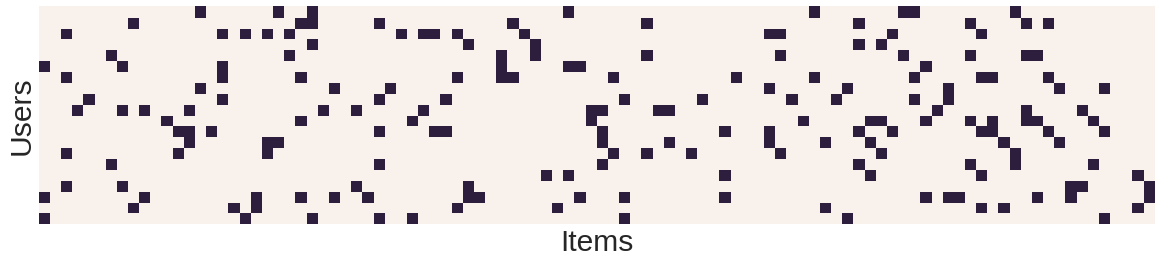

In [1]:
# ipython notebook foo to embed figures
%matplotlib inline

from validation_figs import *

# generate a small, random user-item matrix for illustration
uim, _ = uim_data()

## Defining train and test sets.

For recommenders, the split is often slightly different from the (more) standard approach of splitting the data matrix on rows.  Many recommenders, in fact, need to have *SOME*  item-level information for a user, or it can't make any prediction at all. **We can not exclude any whole row of the user-item matrix off the training set.** So instead, we need to split up the data in more creative ways.

<a id='leave-k-out'></a>
### Leave-k-out 

A common strategy for splitting recommendation data into training and test sets is **leave-k-out**.  Here, a split percentage is chosen (e.g., 80% train, 20% test) and the test percentage is **selected randomly** from the user-item pairs with non-zero entries.

**Randomly select k non-zero user-item matrix entries into test set. **

**Repeat the above step multiple times. **


Choosing an 80%/20% split, we can see the test data highlighted in our example below:

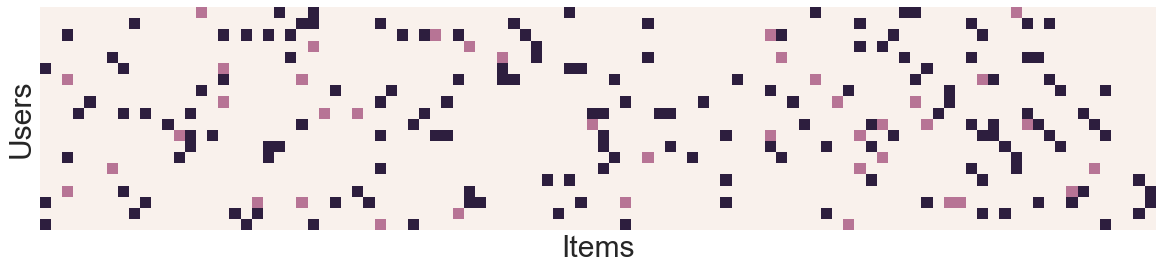

In [20]:
# Leave-k-out demo
leave_k_out(uim.copy(), _)

***Best practices***
* Similar to K-fold cross validation, leave-k-out should be repeated multiple times.  **A minimal version is to repeat by 1 over the test fraction size** - so for 20% test splits, repeat $N=5$ times.  However, since the strategy is random (not stratified) **it is best to repeat multiple $N$ times**.  One can look at the variance of metrics to see how well they are estimated.

<a id='leave-one-out'></a>
### Leave-one-out

The extreme case of leave-k-out is **leave-one-out**, where only one user-item entry is held out for testing. If feasible, training and testing is repeated for every user-item entry in the *entire data set!*  The obvious downside of this approach is the computational demands, which can be large for big datasets. Sometimes, this means people will adopt a strategy of only doing leave-one-out for each user, or randomly selecting one entry and doing this as many times as practical.

***Why would anyone do this?*** In some cases, its hard to have enough training data to build a good model and one may need to maximize the amount of training data available. Alternatively, another situation where leave-one-out is appropriate is when almost all the users have one or two ratings.  This means that under typical leave-k-out, a large number of users will have no entries by which to make predictions.  Using leave-one-out generally requires knowledge and assumptions about the data and model, so Data Scientist beware! Leave-one-out can be quite prone to overfitting.


** leave-one-out is the extreme case of leave-k-out scheme:**

** The leave-one-out method is computational demanding, but ideal for situation when training data is scarce.**

** leave-one-out can be quite prone to overfitting. **


<a id='m-fold'></a>
### M-fold Cross Validation

A useful variant that combines leave-k-out and standard *K-fold* crossvValidation is (sometimes) called ***M-fold cross validation***.  The idea is simple - split the data into a training set and holdout set.  On the holdout set, perform leave-k-out.  

On our example data, lets perform a 50% training and holdout split, and 50% leave-k-out on the holdout set.  This means we are training on 50% of the data, and testing on 25%. 

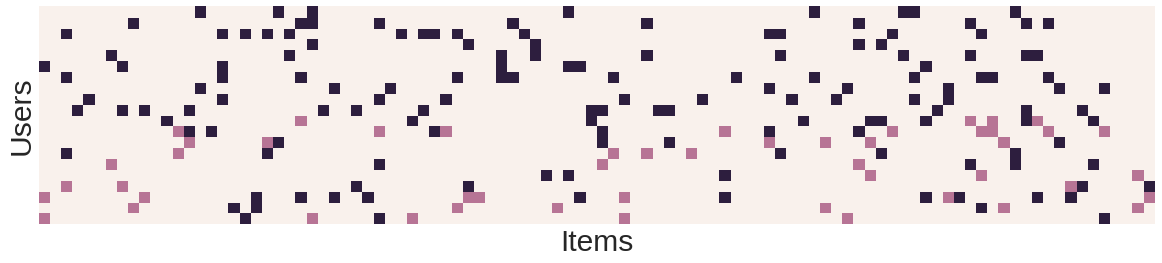

In [2]:
# M-fold demo
M_fold(uim.copy(), _)

***Best practices***
* Like our best practices for leave-k-out, we should repeated the number of tests we do on the holdout data for a given fold.

M-fold cross validation has some nice advantages.  First, the training data is complete - that is, the training data for each user is not missing any data (unlike standard leave-k-out).  This might be an advantage when the typical number of entries for a user is quite low.  Second, integrating the stratified nature of K-fold CV gives us more assurance that we are traversing the dataset, possibly leading to less test evaluations ultimately.  The downside is that one might have to put more care into considering the exact splits of training, holdout, and test proportions.

<a id='validation'></a>
### Validation Sets

Many machine learning models require hyperparameter tuning in order to deliver good performance.  The same is true for a subset of recommender systems.  In these cases, we need a third partitioning of the data - a **validation set**.  The validation set is used during the training process to set the hyperparameters.  This strategy is standard practice to insure best generalized performance.

Selecting a validation set is similar to the process for any other machine learning application.  From the training set, a validation set is selected in a manner similar to how the initial train/test split was generated.  Often the only difference is the relative proportions of the train/test and train/validation splits.

<a id='holdout summary'></a>
### Summary: Holdout recommendations and best practices

* Generally we recommend using leave-k-out or M-fold validation.  Use leave-one-out only when necessary.
* Leave-k-out might be well suited to more balanced (# of user entries fairly consistent) and more dense (# of user entries fairly large) data, while M-fold might preform better elsewhere.
* Think carefully when deciding strategy and split proportions:
    * How much training data does the model need?
    * What is the variance of your estimation of performance metrics?
    * If the data is large, what are the computational and practical trade-offs?
    * Does your strategy bias performance towards different user populations?

<a id='metrics'></a>
# Evaluation Metrics

There are a large variety of **evaluation metrics** we might consider for different recommendation tasks.  This is no single, slam-dunk metric by which recommenders can be evaluated.  Instead, it requires a bit of thinking: What is the goal of the system?  What do zeros in the matrix mean? How much implicitness and exposure are involved in the data collection?  

These are tough questions.  In a real-world, production situation, one *or more* of the below metrics may be used when building out recommenders but ultimately **the gold standard is A/B testing**.  However, A/B testing every possible model is impractical.  Moreover, practitioners developing new recommender models need a means by which to iterate.

This section will walk through various options for metrics, with the goal of giving a high level intuition but enough detail when necessary.  Here we will evaluate the metrics on one data set and one train/test split, using a simple cosine similarity user-user recommender.  To thoroughly evaluate a model, we would do the splitting and metric evaluation multiple times (as needed by the holdout method).  Comparing models is then possible using these (more robust) metrics.

## Data, Train/Test Sets, and Collaborative Filtering

Below, we will used the [MovieLens 100k](http://grouplens.org/datasets/movielens/) dataset.  This dataset is represents a 943 user by 1682 movie matrix, where the entries are **non-binary** ratings of movies **valued 1-5**.  We ship the necessary data file with this notebook.  Let's load the data:

In [2]:
from utils import fetch_movielens_data

# get user-review (i.e., user-item) matrix
urm = fetch_movielens_data()

print 'User-review matrix, shape: (%d, %d)' % urm.shape

User-review matrix, shape: (943, 1682)


For demonstration purposes, lets do one split of training and test sets using an 80%/20% ratio.

note - in this implementation of leave-k-out, the train, test data have the same shape, **but test data is zeroed out in the training set**. In addition, we have imputed values where there are no entries in the matrix.

In [4]:
import numpy as np
from utils import train_test_split
train, test = train_test_split(urm)

# Remember - this is MovieLens 100k, meaning 100k ratings.
print 'Train shape: (%d, %d)' % train.shape
print 'Test shape: (%d, %d)' % test.shape
print 'Zero-valued Train entries: %d' % np.where(train == 0)[0].size
print 'Non-zero Train entries: %d' % np.where(train > 0)[0].size
print 'Test entries: %d' % np.where(test > 0)[0].size
print 'Total entries in imputed user-item matrix: %d' % (train.shape[0] * train.shape[1])

Train shape: (943, 1682)
Test shape: (943, 1682)
Zero-valued Train entries: 20000
Non-zero Train entries: 1566126
Test entries: 20000
Total entries in imputed user-item matrix: 1586126


Finally, lets run our working model - user-user collaborative filtering.  This model uses the cosine similarity between users to predict the ratings of items.  A detailed discussion is beyond the scope of this document but [this blog post](http://blog.ethanrosenthal.com/2015/11/02/intro-to-collaborative-filtering/) has a great discussion, and (coming soon) recommender_systems-algorithms.ipynb will cover the model and possible alternatives.

In [24]:
from algorithms import CosSimilarityRecommender

# init, fit to training data, predict
rec = CosSimilarityRecommender(kind='user')
rec.fit(train)
predictions = rec.predict(train)

<a id='error'></a>
## Error metrics

Error metrics are one of the most used and well known metrics amongst Machine Learning practitioners.  They are useful because they provide (in some sense) a summary of how model predictions perform across a given test set.  The most common is the **Mean Squared Error (MSE)** or similarly **Root Mean Squared Error (RMSE)**.  Lets define the **MSE**:

$$ {\rm MSE} = \frac{1}{N}\sum_{i=1}^{N} (p_i - a_i)^2 $$

Here we sum the squared difference between predicted value $p_i$ and actual value $a_i$ over all $N$ test examples.  The RMSE is simply the square root of this value.  RMSE perhaps more interpretible because it is of the same scale as the data, but nevertheless constains the same information as the MSE.

While the MSE is easy to compute, it can suffer from very large error contributions from **outliers** - squaring the error puts emphasis on large deviations.  A more robust error metric is the **Mean Absolute Error (MAE)**:

$$ {\rm MAE} = \frac{1}{N}\sum_{i=1}^{N} |p_i - a_i| $$,

which is easy to implement and interpret. 

Lets compute the MSE and MAE:

In [25]:
# alternatively:
# from sklearn.metrics import mean_squared_error, mean_absolute_error

# mean squared error
def mse(true, actual):
    return np.mean((true - actual) ** 2.)

# mean absolute error
def mae(true, actual):
    return np.mean(np.abs(true - actual))

nonzero_test = test > 0
print 'MSE = %0.3f' % mse(predictions[nonzero_test], test[nonzero_test])
print 'MAE = %0.3f' % mae(predictions[nonzero_test], test[nonzero_test])

MSE = 1.064
MAE = 0.837


Ok, so what do these numbers mean?  Its hard to say, exactly, because they are compressed summaries of the data.  There may be half of the predictions doing perfectly and half doing badly or all just performing equally well.  This is an argument for always visualizing (or understanding) your errors.  MAE is a bit more interpretible, on face value it says the model is making average errors on the order of 0.8.  For a scale from 1-5, that seems fairly bad!  Again, better dig into the errors.  

***Binary vs. Non-binary data***: MSE and RMSE have clear connections to non-binary data - if we can accurately estimate the user ratings/plays/clicks it would be very useful!  These metrics are also valid for binary data, if the binary predictions/estimates are continuous.  If they are not, classification metrics (below) do just as well.

<a id='class'></a>
## Classification Metrics

Error metrics are great as they can provide a nice summary of how well the model generally performs.  However, one natural goal of recommender systems is to distinguish good recommendations from bad ones. In the binary case, this is very natural - a "1" is a good recommendation.  The distinction from bad/good (0/1) makes perfect sense for binary data.  For non-binary data, a threshold must be chosen such that all ratings above the threshold are good and called "1", while the rest are bad with label "0".

This good/bad, positive/negative framework is the same as binary classification in other machine learning settings.  Therefore, standard classification metrics could be useful here.  Two basic metrics are **precision** and **recall**, which are defined by True Positives $TP$, False Positives $FP$, True Negatives $TN$, and False Negatives $FN$:

$$ {\rm Precision} = \frac{TP}{TP + FP}, {\rm Recall} = \frac{TP}{TP + FN}$$

Precision is the fraction of good/positive/one labels you got correct, out of all the samples you label positive. Recall is the fraction good/positive/one labels you got correct, out of all the true positives.

One metric that combines these two measurements is the **$F_1$ score**:

$$ F_1 = 2 \frac{{\rm precision} \times {\rm recall}}{{\rm precision} + {\rm recall}}$$

which can be viewed as a weighted average of precision and recall.  A perfectly good classfier has a $F_1$ score of 1, while a perfectly bad classifier has a $F_1$ score of zero.

All these metrics are clear once we have defined the threshold of good/bad in our predictions.  For instance, in a binary situation our labels are 0, 1 while our predictions are (almost always) continuous from 0 - 1.  To compare the predictions, we select a threshold (say 0.5), above which we call predictions 1 and below 0.

The choice of the threshold is left to the user, and can be varied depending on desired tradeoffs (for a more in-depth discussion of this threshold, see [this blog](http://blog.insightdatalabs.com/visualizing-classifier-thresholds/)).  Therefore to summarize classification performance generally, we need metrics that can provide summaries over this threshold.  One tool for generating such a metric is the **Receiver Operator Characteristic (ROC)** curve.  It is a plot of the True Positive Rate $TPR$ versus the False Positive Rate $FPR$:

$$ TPR = \frac{TP}{TP + FN}, FPR = \frac{FP}{FP + TN}$$

A summary metric for the ROC curve is its integral - the **Area Under the Curve (ROC-AUC)**.

Lets examine these metrics for the data and model we have been following:

Recall: 0.866
Precision: 0.877
F1 score: 0.871
ROC-AUC: 0.723


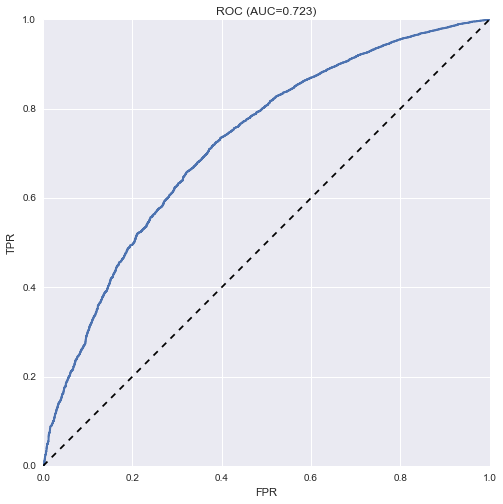

In [26]:
def binarize(arr, tol):
    """
    Convert continous valued array to binary. 
    """
    arr[arr < tol] = 0
    arr[arr >= tol] = 1
    return arr

from sklearn.metrics import recall_score, precision_score, f1_score, roc_curve, roc_auc_score

# get non-zero test entries, since we can't evaluate for unsubmitted ratings!
y_true = test[nonzero_test]
y_pred = predictions[nonzero_test]

# Continous version of predictions, scaled to 0, 1
y_pred_scaled = (y_pred - 1.) / 4.

# binarize true values and predictions
# use the tolerance rating of 3
y_pred_binarized = binarize(y_pred.copy(), 3)
y_true_binarized = binarize(y_true.copy(), 3)

# recall, precision, and f1 are definied for binarized (non-continuous) values 
# of predictions
print 'Recall: %0.3f' % recall_score(y_true_binarized, y_pred_binarized)
print 'Precision: %0.3f' % precision_score(y_true_binarized, y_pred_binarized)
print 'F1 score: %0.3f' % f1_score(y_true_binarized, y_pred_binarized)

# roc-auc is more accurate when using continuous predictions.
auc_score = roc_auc_score(y_true_binarized, y_pred_scaled)
print 'ROC-AUC: %0.3f' % auc_score

# plot ROC curve
fpr, tpr, thresholds = roc_curve(y_true_binarized, y_pred_scaled)
pl.figure(figsize=(8, 8))
pl.plot(fpr, tpr, lw=2)
pl.plot([0, 1], [0, 1], 'k--')
pl.title('ROC (AUC=%0.3f)' % auc_score)
pl.xlabel('FPR')
pl.ylabel('TPR')
pl.show()

Interesting!  According to recall our positive predictions are about 87% pure, and precision says we called 88% of the positive examples 'positive'.  The F1 score is correspondingly high.